In [1]:
import matplotlib.pylab as plt
from skimage import io
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5) # width and height

In [8]:
image = io.imread("Lenna.png")

# variable type
print('variable type:', type(image) )

# data type
print('data type:', image.dtype)    

# print array shape/dimensions
print('array shape:', image.shape)  

# print number of array dimensions
print('number of dimensions:', image.ndim)  

# print number of elements in the array.
print('number of elements:', image.size)  

variable type: <class 'numpy.ndarray'>
data type: uint8
array shape: (512, 512, 3)
number of dimensions: 3
number of elements: 786432


(-0.5, 511.5, 511.5, -0.5)

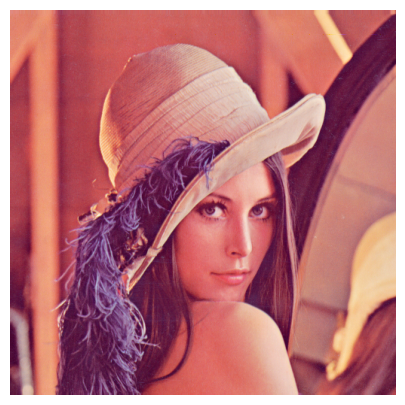

In [6]:
fig, ax = plt.subplots()
ax.imshow(image)
ax.axis('off')